In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

# First look at the data

After importing necessary packages, I will read the data from the file and take a look at the first rows

In [2]:
df = pd.read_csv('data/Graduate - IRISES dataset (2019-06).csv', sep='|')
df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


We can see that the file has been read correctly. Let's invetigate further: check our dataframe's shape, if it contains any missing values, its data types and some summary statistics

In [3]:
df.shape

(150, 5)

In [4]:
df.isna().any()

Sepal.Length    False
Sepal.Width      True
Petal.Length    False
Petal.Width     False
Species         False
dtype: bool

In [5]:
df.describe()

,Sepal.Length,Sepal.Width,Petal.Length
count,150.000000,149.000000,150.000000
mean,5.779333,3.061745,3.758000
std,1.197721,0.433963,1.765298
min,-4.800000,2.000000,1.000000
25%,5.100000,2.800000,1.600000
50%,5.800000,3.000000,4.350000
75%,6.400000,3.300000,5.100000
max,7.900000,4.400000,6.900000


We can see that petal width's summary is not printed! One needs to always check the data types of the variables - it might be the reason of missing summary

In [6]:
df.dtypes

Sepal.Length    float64
Sepal.Width     float64
Petal.Length    float64
Petal.Width      object
Species          object
dtype: object

# Data cleansing

Indeed, the column was interpreted as object, instead of floating point values. We need to fix it! After trying to use standard "astype(float)" command I noticed it is impossible to do it that easily - someone has written a comma instead of a dot.

In [7]:
comma_indicies = df['Petal.Width'].str.contains(',')
df[comma_indicies]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
133,6.4,2.8,5.6,"2,2",virginica


We can see that there is one such value. In this case, I will replace it manually - of course if there was more of such corrupted data I would try a suitable regex. After this fix our "astype(float)" command serves us as expected and we can take a look at the summary of all the columns.

In [8]:
df.loc[comma_indicies, 'Petal.Width'] = 2.2

In [9]:
df['Petal.Width'] = df['Petal.Width'].astype(float)

In [10]:
df.dtypes

Sepal.Length    float64
Sepal.Width     float64
Petal.Length    float64
Petal.Width     float64
Species          object
dtype: object

In [11]:
df.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,149.000000,150.000000,150.000000
mean,5.779333,3.061745,3.758000,1.199333
std,1.197721,0.433963,1.765298,0.762238
min,-4.800000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


It turns out, that one measurement of sepal width is missing. What also looks suspicious is that sepal length got some negative values. Let's take a closer look at the row with missing information first, and then investigate what might be the reason of the negative values

In [12]:
df.loc[df['Sepal.Width'].isna(), :]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
82,5.5,NaN,3.7,1.0,versicolor


In [13]:
df.loc[df['Species'] == 'versicolor'].describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,50.000000,49.000000,50.000000,50.000000
mean,5.936000,2.777551,4.260000,1.326000
std,0.516171,0.312427,0.469911,0.197753
min,4.900000,2.000000,3.000000,1.000000
25%,5.600000,2.600000,4.000000,1.200000
50%,5.900000,2.800000,4.350000,1.300000
75%,6.300000,3.000000,4.600000,1.500000
max,7.000000,3.400000,5.100000,1.800000


We can see that sepal width is really important when one would try to differentiate between irises from versicolor class and other classes. The row with the missing value describe object from that class, so it is really important to impute this value properly. 

I will use median of this variable from that class. 

In [14]:
median_versicolor_sepal_width = np.median(df.loc[(df['Species'] == 'versicolor') & 
                                                 ~(df['Sepal.Width'].isna()), 'Sepal.Width'])

df.loc[df['Sepal.Width'].isna(), 'Sepal.Width'] = median_versicolor_sepal_width

In [15]:
df.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.779333,3.060000,3.758000,1.199333
std,1.197721,0.433032,1.765298,0.762238
min,-4.800000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


After imputing the missing value, I will dive in into sepal lengths. Why are some values negative?

In [16]:
df.loc[df['Sepal.Length'] <= 0.0]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
25,-4.8,3.4,1.9,0.2,setosa


In [17]:
df.loc[df['Species'] == 'setosa'].describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,50.000000,50.000000,50.000000,50.000000
mean,4.814000,3.428000,1.462000,0.246000
std,1.431142,0.379064,0.173664,0.105386
min,-4.800000,2.300000,1.000000,0.100000
25%,4.800000,3.200000,1.400000,0.200000
50%,5.000000,3.400000,1.500000,0.200000
75%,5.200000,3.675000,1.575000,0.300000
max,5.800000,4.400000,1.900000,0.600000


There is only one such value. After looking at summary of irises from setosa class we notice that the absoulte value of the sepal length is very close to the mean for the whole class. Someone has probably just put a minus sign before the number by mistake! Let's fix that

In [18]:
df.loc[df['Sepal.Length'] <= 0.0, 'Sepal.Length'] = np.abs(df.loc[df['Sepal.Length'] <= 0.0, 'Sepal.Length'])

In [19]:
df.loc[df['Species'] == 'setosa'].describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,50.00000,50.000000,50.000000,50.000000
mean,5.00600,3.428000,1.462000,0.246000
std,0.35249,0.379064,0.173664,0.105386
min,4.30000,2.300000,1.000000,0.100000
25%,4.80000,3.200000,1.400000,0.200000
50%,5.00000,3.400000,1.500000,0.200000
75%,5.20000,3.675000,1.575000,0.300000
max,5.80000,4.400000,1.900000,0.600000


# Univariate analysis

Looks much better now! Summary statistics are useful for noticing bugs like the ones I've noticed, but sometimes we may miss something. This is where visaulizations come to play - we can plot distributions of our variables and understand them better.

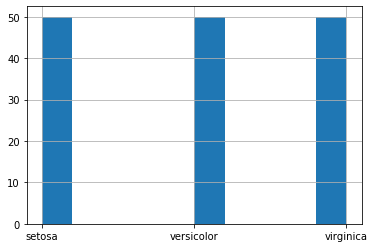

In [20]:
df['Species'].hist();

The classes are evenly distributed

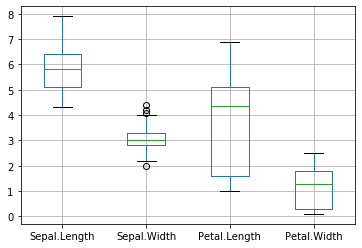

In [21]:
df.boxplot(column=['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']);

Boxplots allow us to take a look at distributions of continuous variables. We can see that sepal width variable has some values below the first quartile and above the third quartile, but not very much.

Histograms and distribution plots will allow us to take a closer look.

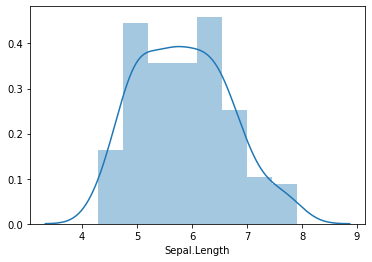

In [22]:
sns.distplot(df['Sepal.Length']);

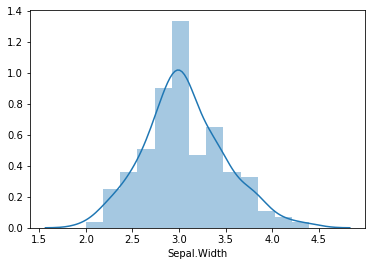

In [23]:
sns.distplot(df['Sepal.Width']);

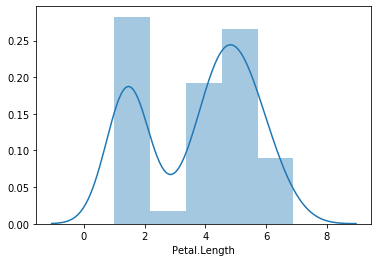

In [24]:
sns.distplot(df['Petal.Length']);

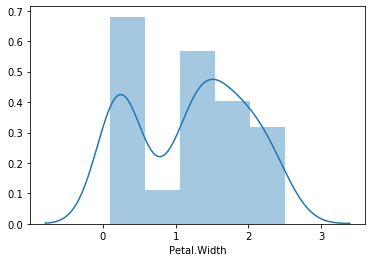

In [25]:
sns.distplot(df['Petal.Width']);

The distributions look ok, there is not much skew in them. Petal length and petal width seem to be bimodal distributions - we can hope that there might be differences in values of this variables depending on the class. Pairplot will help us discover such dependencies.

# Multivariate analysis

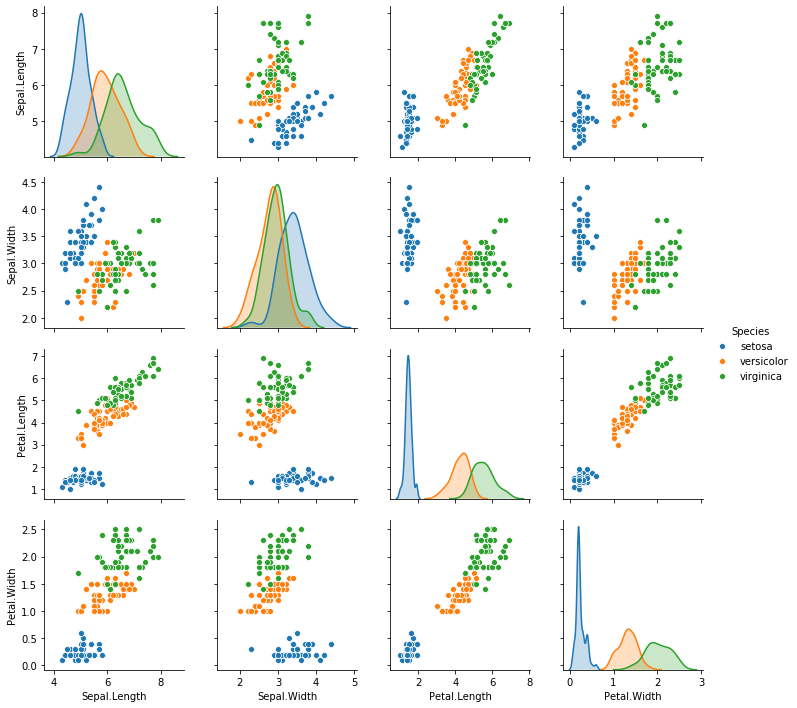

In [26]:
sns.pairplot(df, hue="Species");

At the diagonal we can see the same variable distributions as I plotted before, but this tame different classes are marked with different colors. By looking at this plots we can see that the distribution of petal length and width for class setosa differ from other classes. We learned that versicolor and verginica are more similar to each other than to setosa only by looking at our data!

The scatter plots help us discover some correlations between the variables, and for example petal length and petal width seem to be positively correlated. It is quite logical - the longer the petal the wider it is. There are also some other dependencies, like the one between sepal length and petal width, or sepal length and petal length.

In [27]:
corr1, p1 = pearsonr(df['Petal.Width'], df['Petal.Length'])
print(f'Correlation between peral width and length: {round(corr1, 3)}, p-val: {p1}')

Correlation between peral width and length: 0.963, p-val: 4.6750039073275495e-86


In [28]:
corr2, p2 = pearsonr(df['Petal.Width'], df['Sepal.Length'])
print(f'Correlation between peral width and length: {round(corr2, 3)}, p-val: {p2}')

Correlation between peral width and length: 0.818, p-val: 2.325498079793167e-37


In [29]:
corr3, p3 = pearsonr(df['Petal.Length'], df['Sepal.Length'])
print(f'Correlation between peral width and length: {round(corr3, 3)}, p-val: {p3}')

Correlation between peral width and length: 0.872, p-val: 1.0386674194497525e-47


There are strong linear relationships between the variables. Their corresponding p-values are very small, indicating that the correlation truly exist.

It is very useful piece of information, because it helps us choose our classification model. If there are dependencies between variables one shouln't use linear models because the presence of such dependencies violate its assumption that the variables are independent from each other. In this situation we should model the dependencies directly, or use different kind of model, that is able to handle that, for example a decision tree.

# Classification

The data has been cleaned, and we got some understandying of it. I will work on classification now. First, I will use decision tree and KNN for my baselines, and then check how some more sophisticated models perform compared to the baseline. For KNN one necessary step is to scale the data to make all the features equally important for the model.

KNN accuracy: 1.0


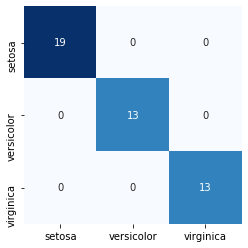

In [30]:
df_train_test = df.copy()
y, X = df_train_test.pop('Species'), df_train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn_classifier', KNeighborsClassifier(n_neighbors=5))
])

knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(f'KNN accuracy: {accuracy_score(y_test, knn_pred)}')

knn_cm = confusion_matrix(y_test, knn_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(knn_cm, cmap='Blues', annot=True, square=True, cbar=False, 
            xticklabels=knn['knn_classifier'].classes_, 
            yticklabels=knn['knn_classifier'].classes_)
plt.show()

To my suprise KNN works really well for this problem! It is always worth to check how simple methods perform, because if they solve the task there is no need to use complex methods that are often more difficult to implement and interprete.

I will also try a decision tree, because it has this nice property that one can always check the rules it has used to model the data.

Decision tree accuracy: 1.0


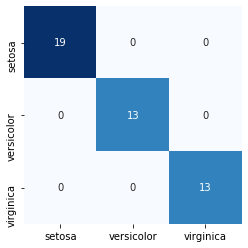

In [31]:
decision_tree = DecisionTreeClassifier(random_state=42)

decision_tree.fit(X_train, y_train)
tree_pred = decision_tree.predict(X_test)
print(f'Decision tree accuracy: {accuracy_score(y_test, tree_pred)}')

tree_cm = confusion_matrix(y_test, tree_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(tree_cm, cmap='Blues', annot=True, square=True, cbar=False, 
            xticklabels=decision_tree.classes_, 
            yticklabels=decision_tree.classes_)
plt.show()

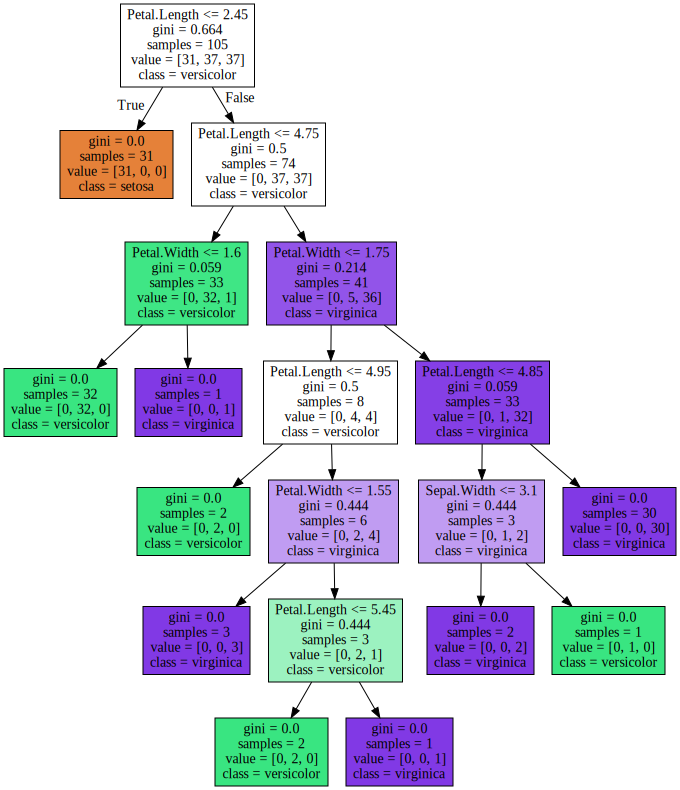

In [32]:
graph = Source(tree.export_graphviz(decision_tree, 
                                    out_file=None, 
                                    feature_names=df.columns[0:4], 
                                    class_names=list(decision_tree.classes_), 
                                    filled = True))

display(SVG(graph.pipe(format='svg')))

Another nice property of decision trees is that they provide natural way to measure feature importance, by checking which feature contributed to the splitting criterion the most. We can see that petal length is really important. 

One can notice that in the plotted tree it was the most common feature used to partition the data.

In [33]:
pd.DataFrame(decision_tree.feature_importances_, 
             columns=['importance'], index=X_train.columns).sort_values('importance', ascending=False)

,importance
Petal.Length,0.893264
Petal.Width,0.087626
Sepal.Width,0.019110
Sepal.Length,0.000000
